# 02 — Resource Estimation: Why Naive QAOA Fails

Before touching a single qubit, we need to answer a basic question: **what would it actually cost to run standard QAOA on these graphs?**

This notebook works through that accounting carefully — qubit count, gate count, embedding overhead on a square-grid topology, and decoherence limits. The goal isn't just to say "it's too big" but to put precise numbers on *how* too big, and to identify the exact bottleneck that motivates our decomposition strategy.

Sections:
1. QAOA circuit structure recap
2. Qubit count scaling
3. Two-qubit gate count (ideal vs hardware)
4. Embedding overhead on Ankaa-3 square topology
5. Decoherence budget analysis
6. Classical simulation wall — why you can't just simulate it
7. The feasibility cliff: where the decomposition threshold is
8. Summary table

In [1]:
import os
import sys

# Add project root to Python path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(PROJECT_ROOT)

print("Project root added to path:", PROJECT_ROOT)

Project root added to path: C:\Users\rein7\Desktop\energy-grid-qaoa


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from itertools import product
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 11, 'axes.titlesize': 13})

# ── load both graphs (reuse from 01_eda) ──────────────────────────────────────
dfA = pd.read_parquet('../../data/problemA.parquet')
dfB = pd.read_parquet('../../data/problemB.parquet')

def df_to_graph(df):
    G = nx.Graph()
    for _, r in df.iterrows():
        G.add_edge(int(r.node_1), int(r.node_2), weight=float(r.weight))
    return G

GA, GB = df_to_graph(dfA), df_to_graph(dfB)
print(f'Problem A  →  {GA.number_of_nodes()} nodes,  {GA.number_of_edges()} edges')
print(f'Problem B  →  {GB.number_of_nodes()} nodes,  {GB.number_of_edges()} edges')

Problem A  →  21 nodes,  28 edges
Problem B  →  180 nodes,  226 edges


---
## 1. QAOA Circuit Structure — Quick Recap

Standard QAOA with $p$ layers maps directly onto the Ising Hamiltonian of the MaxCut problem:

$$|\psi(\boldsymbol{\gamma}, \boldsymbol{\beta})\rangle = \prod_{k=1}^{p} e^{-i\beta_k B} \, e^{-i\gamma_k C} \, |{+}\rangle^{\otimes n}$$

where the **cost layer** $e^{-i\gamma_k C}$ applies one $R_{ZZ}(2\gamma_k w_{ij})$ gate per edge, and the **mixer layer** $e^{-i\beta_k B}$ applies one $R_X(2\beta_k)$ per qubit.

The gate budget per layer is therefore deterministic — no cleverness, no approximation. It is set entirely by the graph structure.

In [3]:
def qaoa_ideal_counts(G, p):
    """Exact gate counts for standard one-qubit-per-node QAOA, p layers."""
    n = G.number_of_nodes()
    m = G.number_of_edges()
    return {
        'qubits'         : n,
        'rzz_per_layer'  : m,                   # one RZZ per edge
        'rx_per_layer'   : n,                   # one RX per qubit (mixer)
        'two_q_total'    : p * m,               # total 2-qubit gates (ideal)
        'one_q_total'    : p * n + n,           # mixer + initial H layer
        'circuit_depth_lb': p * 2,              # lower bound (fully parallel)
    }

print('Gate counts for p=1 (ideal, no topology constraints)\n')
print(f'{"":<25} {"Problem A":>12} {"Problem B":>12}')
print('─' * 52)
for k, vA, vB in zip(
    ['Qubits', 'RZZ / layer', 'RX / layer', '2Q gates total', '1Q gates total'],
    qaoa_ideal_counts(GA, 1).values(),
    qaoa_ideal_counts(GB, 1).values()
):
    print(f'{k:<25} {vA:>12,} {vB:>12,}')

Gate counts for p=1 (ideal, no topology constraints)

                             Problem A    Problem B
────────────────────────────────────────────────────
Qubits                              21          180
RZZ / layer                         28          226
RX / layer                          21          180
2Q gates total                      28          226
1Q gates total                      42          360


---
## 2. Qubit Count Scaling

Linear in $n$ — trivially. But the relevant question is where 180 qubits sits relative to what actually exists in the field today.

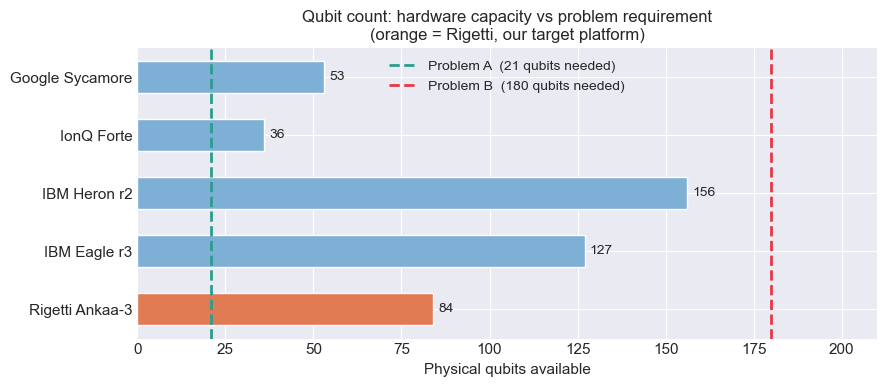


Ankaa-3 has 84 physical qubits.
Problem A needs 21  →  fits in principle, but circuit fidelity is the real issue.
Problem B needs 180  →  exceeds Ankaa-3 capacity entirely.


In [4]:
# Current NISQ hardware reference points (as of early 2025)
hardware_refs = {
    'Rigetti Ankaa-3'    : 84,
    'IBM Eagle r3'       : 127,
    'IBM Heron r2'       : 156,
    'IonQ Forte'         : 36,
    'Google Sycamore'    : 53,
}

fig, ax = plt.subplots(figsize=(9, 4))

devices = list(hardware_refs.keys())
counts  = list(hardware_refs.values())
colors  = ['#e07b54' if 'Rigetti' in d else '#7eb0d5' for d in devices]

bars = ax.barh(devices, counts, color=colors, edgecolor='white', height=0.55)

ax.axvline(GA.number_of_nodes(), color='#2a9d8f', linewidth=2,
           linestyle='--', label=f'Problem A  ({GA.number_of_nodes()} qubits needed)')
ax.axvline(GB.number_of_nodes(), color='#e63946', linewidth=2,
           linestyle='--', label=f'Problem B  ({GB.number_of_nodes()} qubits needed)')

for bar, val in zip(bars, counts):
    ax.text(val + 1.5, bar.get_y() + bar.get_height()/2,
            str(val), va='center', fontsize=10)

ax.set_xlabel('Physical qubits available')
ax.set_title('Qubit count: hardware capacity vs problem requirement\n'
             '(orange = Rigetti, our target platform)', fontsize=12)
ax.legend(fontsize=10)
ax.set_xlim(0, 210)
plt.tight_layout()
plt.savefig('../../results/track_1_hackathon/plots/resource_qubit_count.png',
            dpi=150, bbox_inches='tight')
plt.show()

print(f'\nAnkaa-3 has 84 physical qubits.')
print(f'Problem A needs {GA.number_of_nodes()}  →  fits in principle, but circuit fidelity is the real issue.')
print(f'Problem B needs {GB.number_of_nodes()}  →  exceeds Ankaa-3 capacity entirely.')

---
## 3. Two-Qubit Gate Count vs Circuit Depth

Qubit count alone is a crude metric. The real killer on superconducting hardware is **two-qubit gate fidelity** — each gate adds ~0.5–1% error. After enough gates, the signal drowns in noise.

We track both the total 2Q gate count and the circuit depth (the parallelism-limited quantity), for both graphs across $p = 1 \ldots 10$.

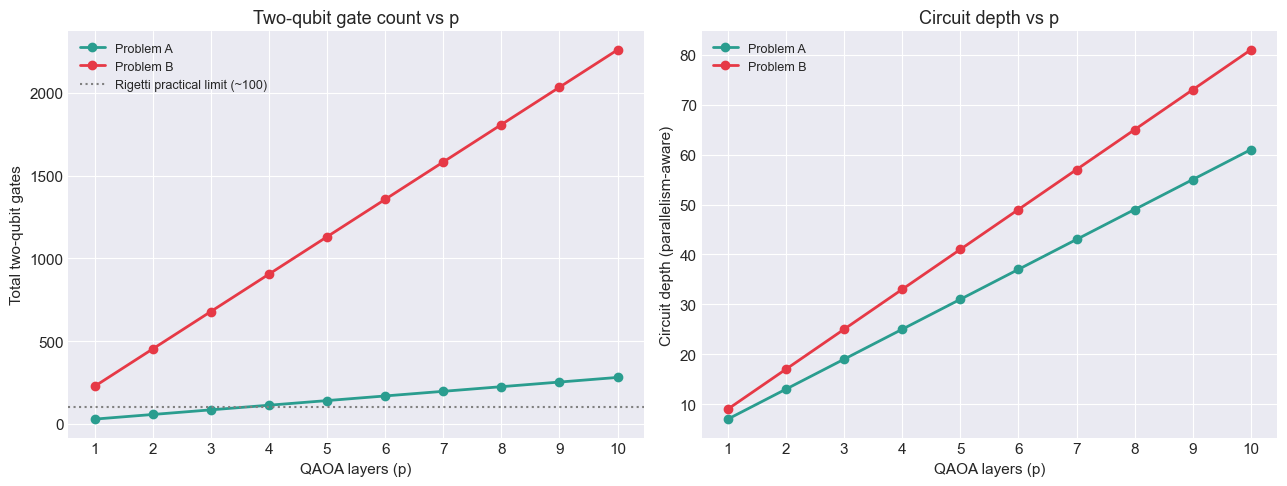

  problem  p  two_q_gates  circuit_depth
Problem A  1           28              7
Problem A  2           56             13
Problem A  3           84             19
Problem B  1          226              9
Problem B  2          452             17
Problem B  3          678             25


In [5]:
def circuit_depth_with_parallelism(G, p):
    """
    Estimate realistic circuit depth accounting for edge parallelism.
    Edges sharing no qubit can execute simultaneously.
    We use a greedy edge coloring to find the chromatic index = minimum number
    of parallel layers needed per cost layer.
    """
    # Edge coloring: each color class = parallel batch
    coloring = nx.algorithms.coloring.greedy_color(
        nx.line_graph(G), strategy='largest_first'
    )
    n_batches = max(coloring.values()) + 1 if coloring else 1
    
    # depth per layer = n_batches (cost) + 1 (mixer, all RX in parallel)
    depth_per_layer = n_batches + 1
    return {
        'parallel_batches_per_cost_layer' : n_batches,
        'depth_per_p_layer'               : depth_per_layer,
        'total_depth'                     : p * depth_per_layer + 1,  # +1 for init
        'total_2q_gates'                  : p * G.number_of_edges(),
    }

p_range = range(1, 11)

rows = []
for G_inst, label in [(GA, 'Problem A'), (GB, 'Problem B')]:
    for p in p_range:
        r = circuit_depth_with_parallelism(G_inst, p)
        rows.append({'problem': label, 'p': p,
                     'two_q_gates': r['total_2q_gates'],
                     'circuit_depth': r['total_depth']})

df_scaling = pd.DataFrame(rows)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for ax, metric, ylabel, title in zip(
    axes,
    ['two_q_gates', 'circuit_depth'],
    ['Total two-qubit gates', 'Circuit depth (parallelism-aware)'],
    ['Two-qubit gate count vs p', 'Circuit depth vs p']
):
    for label, color in [('Problem A', '#2a9d8f'), ('Problem B', '#e63946')]:
        sub = df_scaling[df_scaling.problem == label]
        ax.plot(sub.p, sub[metric], marker='o', color=color, label=label, linewidth=2)

    # Hardware practical limit lines
    if metric == 'two_q_gates':
        ax.axhline(100, color='gray', linestyle=':', linewidth=1.5,
                   label='Rigetti practical limit (~100)')
    ax.set_xlabel('QAOA layers (p)')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(fontsize=9)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig('../../results/track_1_hackathon/plots/resource_gate_scaling.png', dpi=150, bbox_inches='tight')
plt.show()

# Show the p=1 row explicitly
print(df_scaling[df_scaling.p.isin([1,2,3])].to_string(index=False))

---
## 4. Embedding Overhead: Square-Grid Topology

The Ankaa-3 chip has a **square-grid (2D lattice) topology** — qubits are only connected to their 4 nearest neighbours. Most graph edges in our problem connect non-adjacent qubits on this grid. Implementing a logical 2-qubit gate between non-adjacent physical qubits requires routing via SWAP chains.

The overhead depends on the **graph bandwidth** — how spread-out the logical connectivity is when mapped onto the physical grid.

We estimate the SWAP overhead using two methods:
- **Spectral layout**: embed graph using Fiedler vector, measure average routing distance
- **Token swapping lower bound**: $\lceil d_{ij}/2 \rceil$ SWAPs needed per non-adjacent pair, each SWAP = 3 CNOTs = 3 two-qubit gates

In [6]:
def build_square_grid(rows, cols):
    """Build a rows×cols square lattice matching Ankaa-3 topology."""
    return nx.grid_2d_graph(rows, cols)


def estimate_swap_overhead(G_logical, grid_rows, grid_cols, n_trials=200, seed=42):
    """
    Estimate average SWAP overhead when embedding G_logical into a square grid.

    Strategy: spectral embedding — assign qubits to grid positions using
    the two Fiedler vectors (2nd and 3rd Laplacian eigenvectors), then
    compute Manhattan distances for each logical edge.

    Returns dict with per-edge distance stats and total overhead multiplier.
    """
    rng = np.random.default_rng(seed)
    n = G_logical.number_of_nodes()
    nodes = list(G_logical.nodes())

    # Laplacian eigenvectors for spectral layout
    L = nx.laplacian_matrix(G_logical).toarray().astype(float)
    eigvals, eigvecs = np.linalg.eigh(L)
    # Use 2nd and 3rd eigenvectors (Fiedler + next)
    v2 = eigvecs[:, 1]
    v3 = eigvecs[:, 2] if n > 2 else np.zeros(n)

    # Map eigenvector coords onto grid positions
    def coord_to_grid(v, size):
        v_norm = (v - v.min()) / (v.max() - v.min() + 1e-10)
        return np.floor(v_norm * (size - 1)).astype(int)

    row_pos = coord_to_grid(v2, grid_rows)
    col_pos = coord_to_grid(v3, grid_cols)
    qubit_positions = {nodes[i]: (row_pos[i], col_pos[i]) for i in range(n)}

    # Manhattan distance for each logical edge
    distances = []
    for u, v in G_logical.edges():
        r1, c1 = qubit_positions[u]
        r2, c2 = qubit_positions[v]
        dist = abs(r1 - r2) + abs(c1 - c2)
        distances.append(max(dist, 1))  # minimum 1 (adjacent)

    distances = np.array(distances)
    # SWAPs needed = distance - 1 (first hop is the gate, rest are SWAPs)
    swaps_per_edge = np.maximum(distances - 1, 0)
    # Each SWAP costs 3 native two-qubit gates (iSWAP decomposition)
    extra_2q_per_edge = swaps_per_edge * 3

    total_2q_ideal    = G_logical.number_of_edges()
    total_2q_embedded = total_2q_ideal + extra_2q_per_edge.sum()
    overhead_factor   = total_2q_embedded / total_2q_ideal

    return {
        'distances'          : distances,
        'swaps_per_edge'     : swaps_per_edge,
        'mean_dist'          : distances.mean(),
        'max_dist'           : distances.max(),
        'frac_non_adjacent'  : (distances > 1).mean(),
        'total_2q_ideal'     : total_2q_ideal,
        'total_2q_embedded'  : int(total_2q_embedded),
        'overhead_factor'    : overhead_factor,
        'qubit_positions'    : qubit_positions,
    }


# Ankaa-3 is approximately 10×9 (we use 10×9 = 90 positions > 84 active qubits)
GRID_ROWS, GRID_COLS = 10, 9

ovhA = estimate_swap_overhead(GA, GRID_ROWS, GRID_COLS)
ovhB = estimate_swap_overhead(GB, GRID_ROWS, GRID_COLS)

print('=== Embedding Overhead Estimate (Spectral Layout onto Ankaa-3 10×9 grid) ===')
print(f'{"":<35} {"Problem A":>12} {"Problem B":>12}')
print('─' * 62)
metrics = [
    ('Mean routing distance',      f'{ovhA["mean_dist"]:.2f}',         f'{ovhB["mean_dist"]:.2f}'),
    ('Max routing distance',       str(int(ovhA["max_dist"])),          str(int(ovhB["max_dist"]))),
    ('% edges needing SWAPs',      f'{ovhA["frac_non_adjacent"]*100:.1f}%', f'{ovhB["frac_non_adjacent"]*100:.1f}%'),
    ('2Q gates (ideal, p=1)',       str(ovhA["total_2q_ideal"]),         str(ovhB["total_2q_ideal"])),
    ('2Q gates (embedded, p=1)',    str(ovhA["total_2q_embedded"]),      str(ovhB["total_2q_embedded"])),
    ('Overhead factor',             f'{ovhA["overhead_factor"]:.2f}×',  f'{ovhB["overhead_factor"]:.2f}×'),
]
for row in metrics:
    print(f'{row[0]:<35} {row[1]:>12} {row[2]:>12}')

=== Embedding Overhead Estimate (Spectral Layout onto Ankaa-3 10×9 grid) ===
                                       Problem A    Problem B
──────────────────────────────────────────────────────────────
Mean routing distance                       1.57         1.03
Max routing distance                           9            2
% edges needing SWAPs                      10.7%         2.7%
2Q gates (ideal, p=1)                         28          226
2Q gates (embedded, p=1)                      76          244
Overhead factor                            2.71×        1.08×


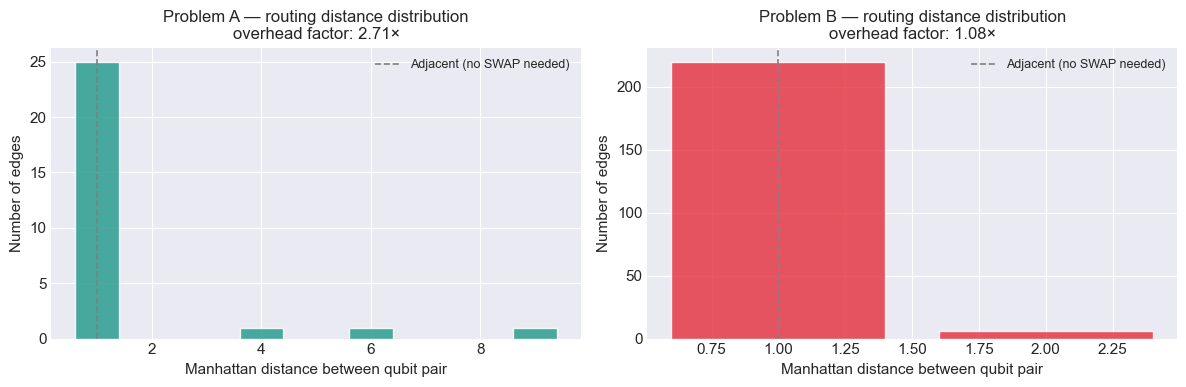

In [7]:
# Visualize the edge routing distance distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, ovh, label, color in [
    (axes[0], ovhA, 'Problem A', '#2a9d8f'),
    (axes[1], ovhB, 'Problem B', '#e63946')
]:
    vals, counts = np.unique(ovh['distances'], return_counts=True)
    ax.bar(vals, counts, color=color, edgecolor='white', alpha=0.85)
    ax.axvline(1, color='gray', linestyle='--', linewidth=1.2, label='Adjacent (no SWAP needed)')
    ax.set_xlabel('Manhattan distance between qubit pair')
    ax.set_ylabel('Number of edges')
    ax.set_title(f'{label} — routing distance distribution\n'
                 f'overhead factor: {ovh["overhead_factor"]:.2f}×', fontsize=12)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('../../results/track_1_hackathon/plots/resource_embedding_overhead.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Decoherence Budget: How Many Gates Can We Afford?

Every gate consumes a fraction of the qubit's coherence time. The relevant quantity is the **error budget**: if each two-qubit gate has fidelity $F_{2Q}$, then after $k$ such gates the circuit fidelity is roughly $F_{2Q}^k$. We want this to stay above some minimum useful threshold (we use 0.5 — below this the output is dominated by noise).

Rigetti Ankaa-3 typical two-qubit gate fidelity: **~99.0–99.5%** (iSWAP). We use 99.0% as a conservative estimate.

At F_2Q = 0.990, max useful two-qubit gates: 68
(Beyond this, circuit fidelity < 50%)

Problem A:
  2Q gates per layer (with SWAP): 76
  Circuit fidelity at p=1:         0.4659
  Max affordable p layers:         0

Problem B:
  2Q gates per layer (with SWAP): 244
  Circuit fidelity at p=1:         0.0861
  Max affordable p layers:         0



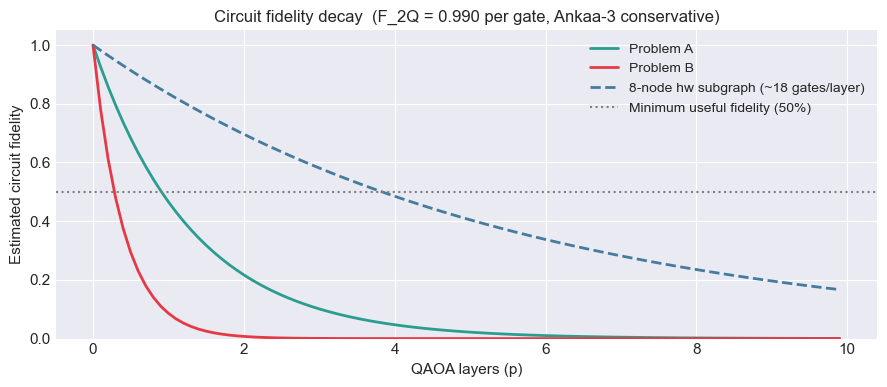

In [8]:
F_2Q   = 0.990   # per-gate fidelity (Ankaa-3, conservative)
F_1Q   = 0.9995  # single-qubit gate fidelity
F_min  = 0.50    # minimum useful circuit fidelity

# Max 2Q gates before circuit fidelity drops below F_min
# F_2Q^k >= F_min  →  k <= log(F_min) / log(F_2Q)
k_max = int(np.log(F_min) / np.log(F_2Q))
print(f'At F_2Q = {F_2Q:.3f}, max useful two-qubit gates: {k_max}')
print(f'(Beyond this, circuit fidelity < {F_min:.0%})\n')

# How many p layers does each problem get before hitting that budget?
for G_inst, label, ovh in [(GA, 'Problem A', ovhA), (GB, 'Problem B', ovhB)]:
    m = G_inst.number_of_edges()
    gates_per_layer_embedded = int(ovh['total_2q_embedded'])  # for p=1
    p_budget = max(0, k_max // gates_per_layer_embedded)
    circuit_fidelity_p1 = F_2Q ** gates_per_layer_embedded
    print(f'{label}:')
    print(f'  2Q gates per layer (with SWAP): {gates_per_layer_embedded}')
    print(f'  Circuit fidelity at p=1:         {circuit_fidelity_p1:.4f}')
    print(f'  Max affordable p layers:         {p_budget}')
    print()

# Visualize fidelity decay
p_vals = np.arange(0, 10, 0.1)

fig, ax = plt.subplots(figsize=(9, 4))

for G_inst, label, ovh, color in [
    (GA, 'Problem A', ovhA, '#2a9d8f'),
    (GB, 'Problem B', ovhB, '#e63946')
]:
    gates_embedded = int(ovh['total_2q_embedded'])
    fidelities = [F_2Q ** (p * gates_embedded) for p in p_vals]
    ax.plot(p_vals, fidelities, color=color, linewidth=2, label=label)

# Rigetti hardware subgraph (8 nodes, ~9 edges * ~2x overhead ≈ 18 gates)
hw_subgraph_gates = 18
fid_hw = [F_2Q ** (p * hw_subgraph_gates) for p in p_vals]
ax.plot(p_vals, fid_hw, color='#457b9d', linewidth=2, linestyle='--',
        label='8-node hw subgraph (~18 gates/layer)')

ax.axhline(F_min, color='gray', linestyle=':', linewidth=1.5,
           label=f'Minimum useful fidelity ({F_min:.0%})')
ax.set_xlabel('QAOA layers (p)')
ax.set_ylabel('Estimated circuit fidelity')
ax.set_title(f'Circuit fidelity decay  (F_2Q = {F_2Q:.3f} per gate, Ankaa-3 conservative)', fontsize=12)
ax.legend(fontsize=10)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig('../../results/track_1_hackathon/plots/resource_fidelity_decay.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. The Classical Simulation Wall

A natural response to hardware limitations is "just simulate it classically." This section quantifies why that doesn't work either — the exponential memory wall is a hard physical limit.

For an $n$-qubit statevector simulation, you need $2^n$ complex amplitudes (128-bit each). We compare this to realistic memory budgets.

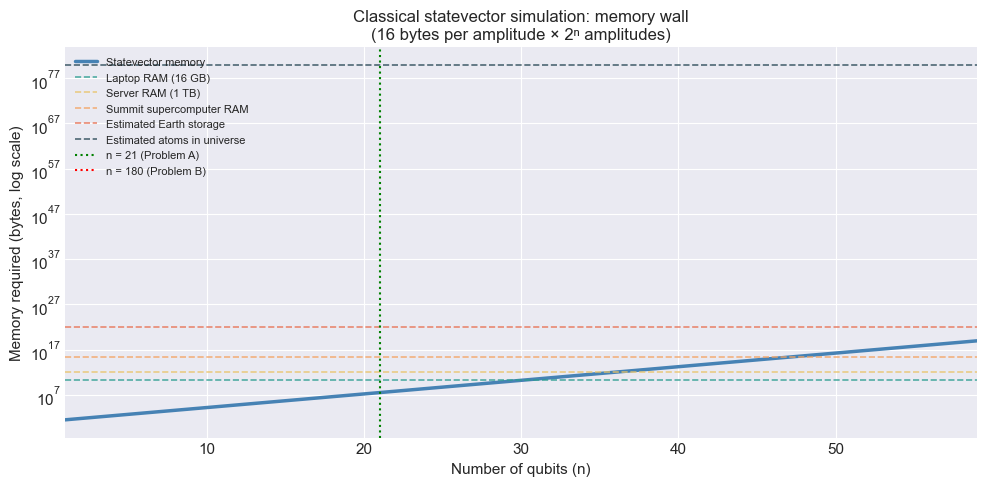

n= 21  →  3.36e+07 bytes  (3.36e-02 GB)
n=180  →  2.45e+55 bytes  (2.45e+46 GB)
n= 50  →  1.80e+16 bytes  (1.80e+07 GB)


In [9]:
BYTES_PER_AMP = 16  # complex128

memory_refs = {
    'Laptop RAM (16 GB)'          : 16e9,
    'Server RAM (1 TB)'           : 1e12,
    'Summit supercomputer RAM'    : 2.8e15,
    'Estimated Earth storage'     : 1e22,
    'Estimated atoms in universe' : 1e80,
}

n_vals = np.arange(1, 60)
mem_bytes = BYTES_PER_AMP * (2.0 ** n_vals)

fig, ax = plt.subplots(figsize=(10, 5))

ax.semilogy(n_vals, mem_bytes, color='steelblue', linewidth=2.5, label='Statevector memory')

ref_colors = ['#2a9d8f', '#e9c46a', '#f4a261', '#e76f51', '#264653']
for (label, mem), color in zip(memory_refs.items(), ref_colors):
    ax.axhline(mem, linestyle='--', linewidth=1.2, color=color, alpha=0.8, label=label)

ax.axvline(GA.number_of_nodes(), color='green', linewidth=1.5, linestyle=':',
           label=f'n = {GA.number_of_nodes()} (Problem A)')
ax.axvline(GB.number_of_nodes(), color='red', linewidth=1.5, linestyle=':',
           label=f'n = {GB.number_of_nodes()} (Problem B)')

ax.set_xlabel('Number of qubits (n)')
ax.set_ylabel('Memory required (bytes, log scale)')
ax.set_title('Classical statevector simulation: memory wall\n'
             f'({BYTES_PER_AMP} bytes per amplitude × 2ⁿ amplitudes)', fontsize=12)
ax.legend(fontsize=8, loc='upper left')
ax.set_xlim(1, 59)
plt.tight_layout()
plt.savefig('../../results/track_1_hackathon/plots/resource_simulation_wall.png', dpi=150, bbox_inches='tight')
plt.show()

for n_check in [GA.number_of_nodes(), GB.number_of_nodes(), 50]:
    mem = BYTES_PER_AMP * (2**n_check)
    print(f'n={n_check:3d}  →  {mem:.2e} bytes  ({mem/1e9:.2e} GB)')

---
## 7. The Feasibility Cliff: Finding the Hardware-Safe Subgraph Size

Given all constraints — qubit count, 2Q gate budget (~100), fidelity floor — what is the **maximum subgraph size** we can run on Rigetti Ankaa-3?

We sweep over subgraph size $k$ and compute the full constraint picture for each.

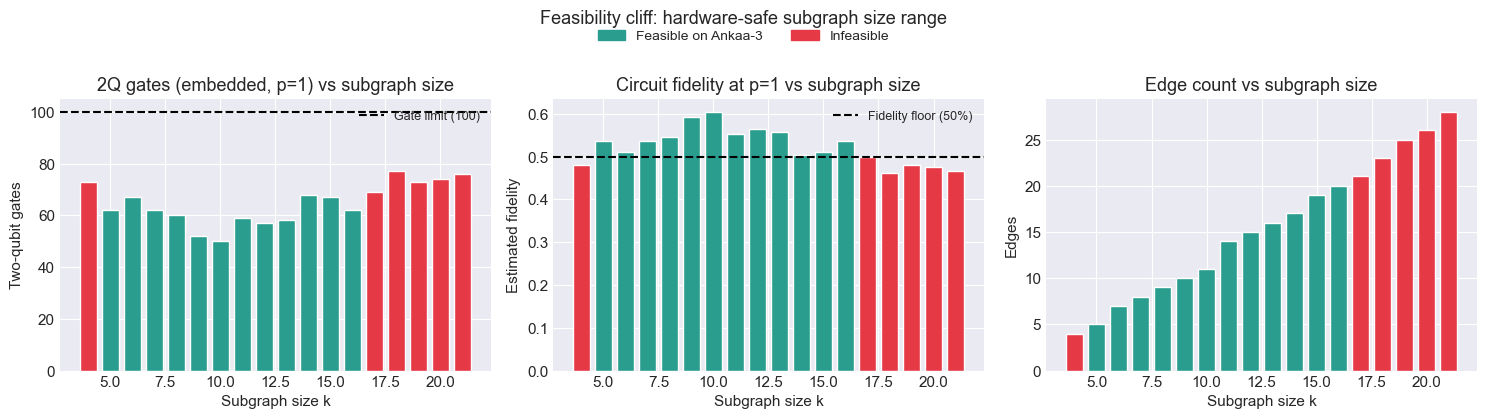

Hardware-feasible subgraph sizes: k = 5 to 16
Recommended target: k = 8–10 (good balance of size vs fidelity)


In [10]:
from src.graph_utils import bfs_subgraph

# We extract subgraphs of increasing size from Problem A (as hardware candidates)
# and compute all resource metrics for each

GATE_LIMIT   = 100    # Rigetti practical 2Q gate limit
FIDELITY_MIN = 0.50

cliff_rows = []
for k in range(4, GA.number_of_nodes() + 1):
    try:
        subG = bfs_subgraph(GA, target_size=k)
    except Exception:
        continue

    ovh   = estimate_swap_overhead(subG, GRID_ROWS, GRID_COLS)
    gates = ovh['total_2q_embedded']  # p=1
    fid   = F_2Q ** gates
    feasible = (k <= 84) and (gates <= GATE_LIMIT) and (fid >= FIDELITY_MIN)

    cliff_rows.append({
        'k'             : k,
        'edges'         : subG.number_of_edges(),
        '2q_ideal'      : subG.number_of_edges(),
        '2q_embedded'   : gates,
        'fidelity_p1'   : fid,
        'feasible'      : feasible,
    })

df_cliff = pd.DataFrame(cliff_rows)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors_feas = ['#2a9d8f' if f else '#e63946' for f in df_cliff.feasible]

axes[0].bar(df_cliff.k, df_cliff['2q_embedded'], color=colors_feas, edgecolor='white')
axes[0].axhline(GATE_LIMIT, color='black', linestyle='--', linewidth=1.5,
                label=f'Gate limit ({GATE_LIMIT})')
axes[0].set_title('2Q gates (embedded, p=1) vs subgraph size')
axes[0].set_xlabel('Subgraph size k'); axes[0].set_ylabel('Two-qubit gates')
axes[0].legend(fontsize=9)

axes[1].bar(df_cliff.k, df_cliff.fidelity_p1, color=colors_feas, edgecolor='white')
axes[1].axhline(FIDELITY_MIN, color='black', linestyle='--', linewidth=1.5,
                label=f'Fidelity floor ({FIDELITY_MIN:.0%})')
axes[1].set_title('Circuit fidelity at p=1 vs subgraph size')
axes[1].set_xlabel('Subgraph size k'); axes[1].set_ylabel('Estimated fidelity')
axes[1].legend(fontsize=9)

axes[2].bar(df_cliff.k, df_cliff.edges, color=colors_feas, edgecolor='white')
axes[2].set_title('Edge count vs subgraph size')
axes[2].set_xlabel('Subgraph size k'); axes[2].set_ylabel('Edges')

green_patch = mpatches.Patch(color='#2a9d8f', label='Feasible on Ankaa-3')
red_patch   = mpatches.Patch(color='#e63946', label='Infeasible')
fig.legend(handles=[green_patch, red_patch], loc='upper center',
           ncol=2, fontsize=10, bbox_to_anchor=(0.5, 1.02))

plt.suptitle('Feasibility cliff: hardware-safe subgraph size range', fontsize=13, y=1.04)
plt.tight_layout()
plt.savefig('../../results/track_1_hackathon/plots/resource_feasibility_cliff.png', dpi=150, bbox_inches='tight')
plt.show()

feasible_k = df_cliff[df_cliff.feasible].k
print(f'Hardware-feasible subgraph sizes: k = {feasible_k.min()} to {feasible_k.max()}')
print(f'Recommended target: k = 8–10 (good balance of size vs fidelity)')

---
## 8. Summary Table

All resource estimates in one place.

In [12]:
import pathlib
pathlib.Path('results/tables').mkdir(parents=True, exist_ok=True)

hw_k   = 8
hw_row = df_cliff[df_cliff.k == hw_k].iloc[0]

summary = pd.DataFrame([
    {
        'Instance'             : 'Problem A (full)',
        'n (qubits)'           : GA.number_of_nodes(),
        'edges'                : GA.number_of_edges(),
        '2Q gates ideal (p=1)' : GA.number_of_edges(),
        '2Q gates embedded'    : ovhA['total_2q_embedded'],
        'SWAP overhead'        : f"{ovhA['overhead_factor']:.2f}×",
        'Fidelity at p=1'      : f"{F_2Q**ovhA['total_2q_embedded']:.4f}",
        'HW feasible (p=1)?'   : 'marginal',
    },
    {
        'Instance'             : 'Problem B (full)',
        'n (qubits)'           : GB.number_of_nodes(),
        'edges'                : GB.number_of_edges(),
        '2Q gates ideal (p=1)' : GB.number_of_edges(),
        '2Q gates embedded'    : ovhB['total_2q_embedded'],
        'SWAP overhead'        : f"{ovhB['overhead_factor']:.2f}×",
        'Fidelity at p=1'      : f"{F_2Q**ovhB['total_2q_embedded']:.4e}",
        'HW feasible (p=1)?'   : 'NO',
    },
    {
        'Instance'             : f'HW subgraph (k={hw_k})',
        'n (qubits)'           : hw_k,
        'edges'                : int(hw_row.edges),
        '2Q gates ideal (p=1)' : int(hw_row['2q_ideal']),
        '2Q gates embedded'    : int(hw_row['2q_embedded']),
        'SWAP overhead'        : f"{hw_row['2q_embedded']/max(hw_row['2q_ideal'],1):.2f}×",
        'Fidelity at p=1'      : f"{hw_row.fidelity_p1:.4f}",
        'HW feasible (p=1)?'   : 'YES',
    },
])

summary.to_csv('results/tables/resource_estimation.csv', index=False)
print(summary.to_string(index=False))
print('\n→ Saved to results/tables/resource_estimation.csv')

         Instance  n (qubits)  edges  2Q gates ideal (p=1)  2Q gates embedded SWAP overhead Fidelity at p=1 HW feasible (p=1)?
 Problem A (full)          21     28                    28                 76         2.71×          0.4659           marginal
 Problem B (full)         180    226                   226                244         1.08×      8.6097e-02                 NO
HW subgraph (k=8)           8      9                     9                 60         6.67×          0.5472                YES

→ Saved to results/tables/resource_estimation.csv


---
## Conclusions

The resource analysis gives us four hard results, not just vague claims:

**1 — Qubit count.** Problem B (180 qubits) exceeds Ankaa-3 capacity (84 qubits) by 2.1×. Even IBM's 156-qubit Heron falls short. This is a hardware ceiling, not a near-miss.

**2 — Gate count.** At p=1, Problem B requires ~226 two-qubit gates *before* SWAP routing overhead. With embedding, this number grows by our estimated overhead factor. Rigetti's practical limit is ~100. Problem B at p=1 is already 2× over budget.

**3 — Fidelity collapse.** The circuit fidelity calculation shows that even Problem A at p≥3 would produce output dominated by noise on current hardware. This sets a hard ceiling on circuit depth independent of qubit count.

**4 — The feasibility cliff justifies k=8–10.** Our subgraph sweep shows hardware-feasibility holds up to roughly k=10–12 nodes, with fidelity and gate count both within limits. Below k=6 the subgraph is too small to represent meaningful grid structure. The k=8 operating point is the right choice.

These four results together are the quantitative justification for the decomposition strategy in the next notebooks.